<a href="https://colab.research.google.com/github/Mayar215999/data-science-project/blob/main/Model_agnostic_Explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0

# install imbalanced-learn package
!pip install lime==0.2.0.1

# Note: If your environment doesn't support "!mamba install", use "!pip install"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a5f955c339ab6378e6910833c7e8cc64cd23610e808e34407b825db0c50115cf
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
## Import packages here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lime.lime_tabular

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree


In [ ]:
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/hr_new_job_processed.csv"
job_df=pd.read_csv(url)

In [ ]:
job_df.describe()

,city_development_index,training_hours,company_size,experience,education_level,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,target
count,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000,11504.000000
mean,0.806056,64.380421,2.748997,9.530985,2.131568,0.029180,0.042537,0.023619,0.005557,0.045442,0.853665,0.500000
std,0.128302,59.048600,1.783676,6.733267,0.627610,0.161802,0.197495,0.147348,0.070875,0.200717,0.342167,0.500022
min,0.448000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.682000,23.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.878000,46.000000,2.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000
75%,0.920000,88.000000,3.000000,15.000000,2.247823,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,0.949000,336.000000,7.000000,21.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X = job_df.loc[:, job_df.columns != 'target']
y = job_df[['target']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 12)

In [ ]:
# Define a black-box random forest model
black_box_model = RandomForestClassifier(random_state = 123, max_depth=25,
                             max_features=10, n_estimators=100,
                             bootstrap=True)
# Train the model
black_box_model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=25, max_features=10, random_state=123)

In [ ]:
#predicting test set
y_blackbox = black_box_model.predict(X_test)

In [ ]:
metrics.roc_auc_score(y_test, y_blackbox)

0.8131250708268802

Your AUC score should be around 0.81, which indicates the model is doing a very good job in the test dataset.

Now we have a black-box random forest model trained, we want to use various model-agnostic methods to explain it.

Note that if you prefer other binary classification models such as XGBoosting, you could train one here by yourself as well, and it won't affect the subsequent steps since our explanations are all model-agnostic.

Permutation Feature Importance
One common way to explain a machine learning model is via finding its important features and permutation feature importance is a popular method to calculate feature importance.

The basic idea of permutation feature importance is we shuffle interested feature values and make predictions using the shuffled values. The feature importance will be measured by calculating the difference between the prediction errors before and after permutation.

In this lab, we will use permutation_importance function provided by sklearn to easily calculate importance for all features.







You can call permutation_importance with the following key arguments:

estimator the model to be estimated
X training data X
y target labels y
n_repeats, Number of times to permute a feature, each permutation generates an importance value

In [ ]:
# Use permutation_importance to calculate permutation feature importances
feature_importances = permutation_importance(estimator=black_box_model, X = X_train, y = y_train, n_repeats=5,
                                random_state=123, n_jobs=2)

In [ ]:
feature_importances.importances.shape

(11, 5)

In [ ]:
feature_importances.importances

array([[0.30468326, 0.30109747, 0.30392263, 0.30174943, 0.30479192],
       [0.15527545, 0.15103771, 0.15092904, 0.15190699, 0.15603608],
       [0.18200587, 0.18309247, 0.18537433, 0.18254917, 0.18993806],
       [0.15353689, 0.15114637, 0.15168967, 0.1472346 , 0.1562534 ],
       [0.1201782 , 0.11789634, 0.11561447, 0.11659242, 0.11517983],
       [0.00076062, 0.00065196, 0.00097794, 0.0005433 , 0.0005433 ],
       [0.00206454, 0.00206454, 0.0021732 , 0.00206454, 0.0016299 ],
       [0.00130392, 0.00141258, 0.00141258, 0.00152124, 0.00119526],
       [0.00076062, 0.0005433 , 0.00065196, 0.0005433 , 0.0005433 ],
       [0.00988808, 0.01043138, 0.00988808, 0.01097468, 0.01097468],
       [0.04813648, 0.04857112, 0.04563729, 0.04704988, 0.04900576]])

It is a 11 x 5 numpy array, 11 means we have 11 features, and 5 represents the total number of permutation times.

For each permutation, we will have a list of importance score calculated for each feature. The value represents the portion of increased prediction errors, important features will have larger values.


However, the feature importance array above is very difficult to comprehend, let's sort and visualize it:

In [ ]:
def visualize_feature_importance(importance_array):
    # Sort the array based on mean value
    sorted_idx = importance_array.importances_mean.argsort()
    # Visualize the feature importances using boxplot
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(10)
    fig.tight_layout()
    ax.boxplot(importance_array.importances[sorted_idx].T,
               vert=False, labels=X_train.columns[sorted_idx])
    ax.set_title("Permutation Importances (train set)")
    plt.show()

<ipython-input-14-d7a48c0d00a8>:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(importance_array.importances[sorted_idx].T,


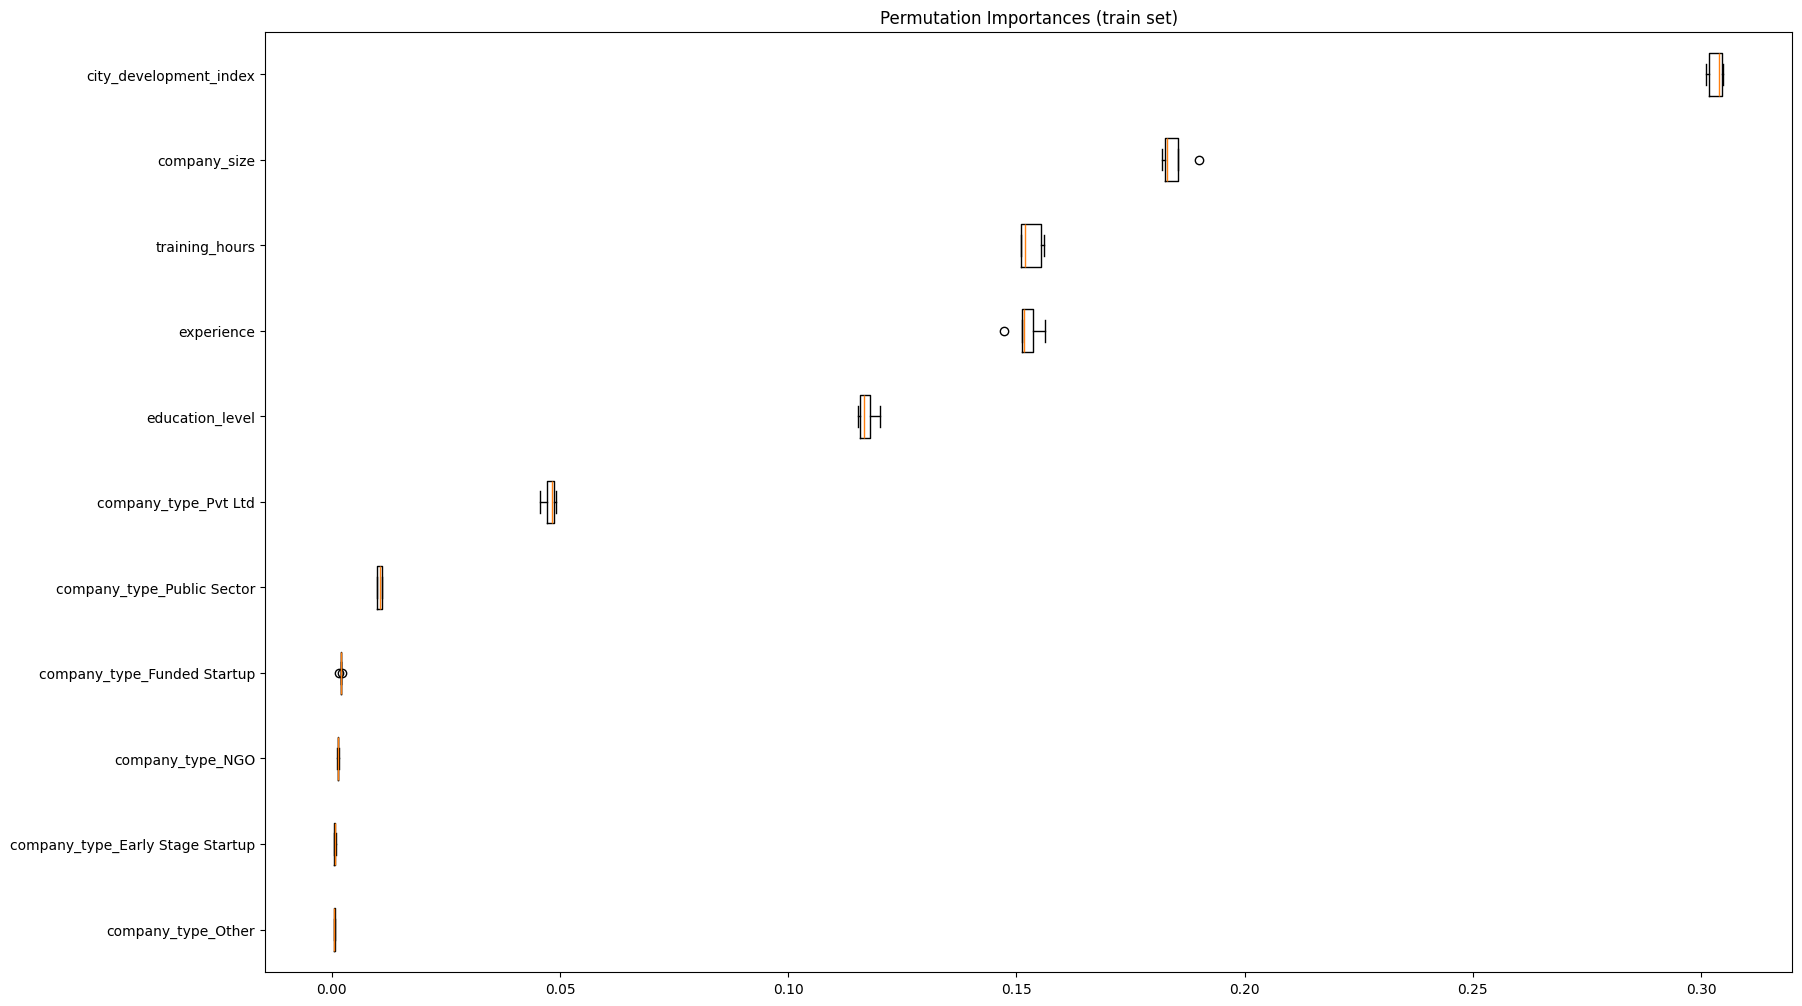

In [ ]:
visualize_feature_importance(feature_importances)

Now you should see a box plot show ranked feature importances, and we can see the most important features are city_development_index, company_size, training_hours, experiences, education_level, and so on, and you should have a general understanding of how the black-box model determines if an employee is looking for a new job or not.


Exercise: Use a different n_repeats=10 to calculate and visualize feature importance values

<ipython-input-14-d7a48c0d00a8>:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(importance_array.importances[sorted_idx].T,


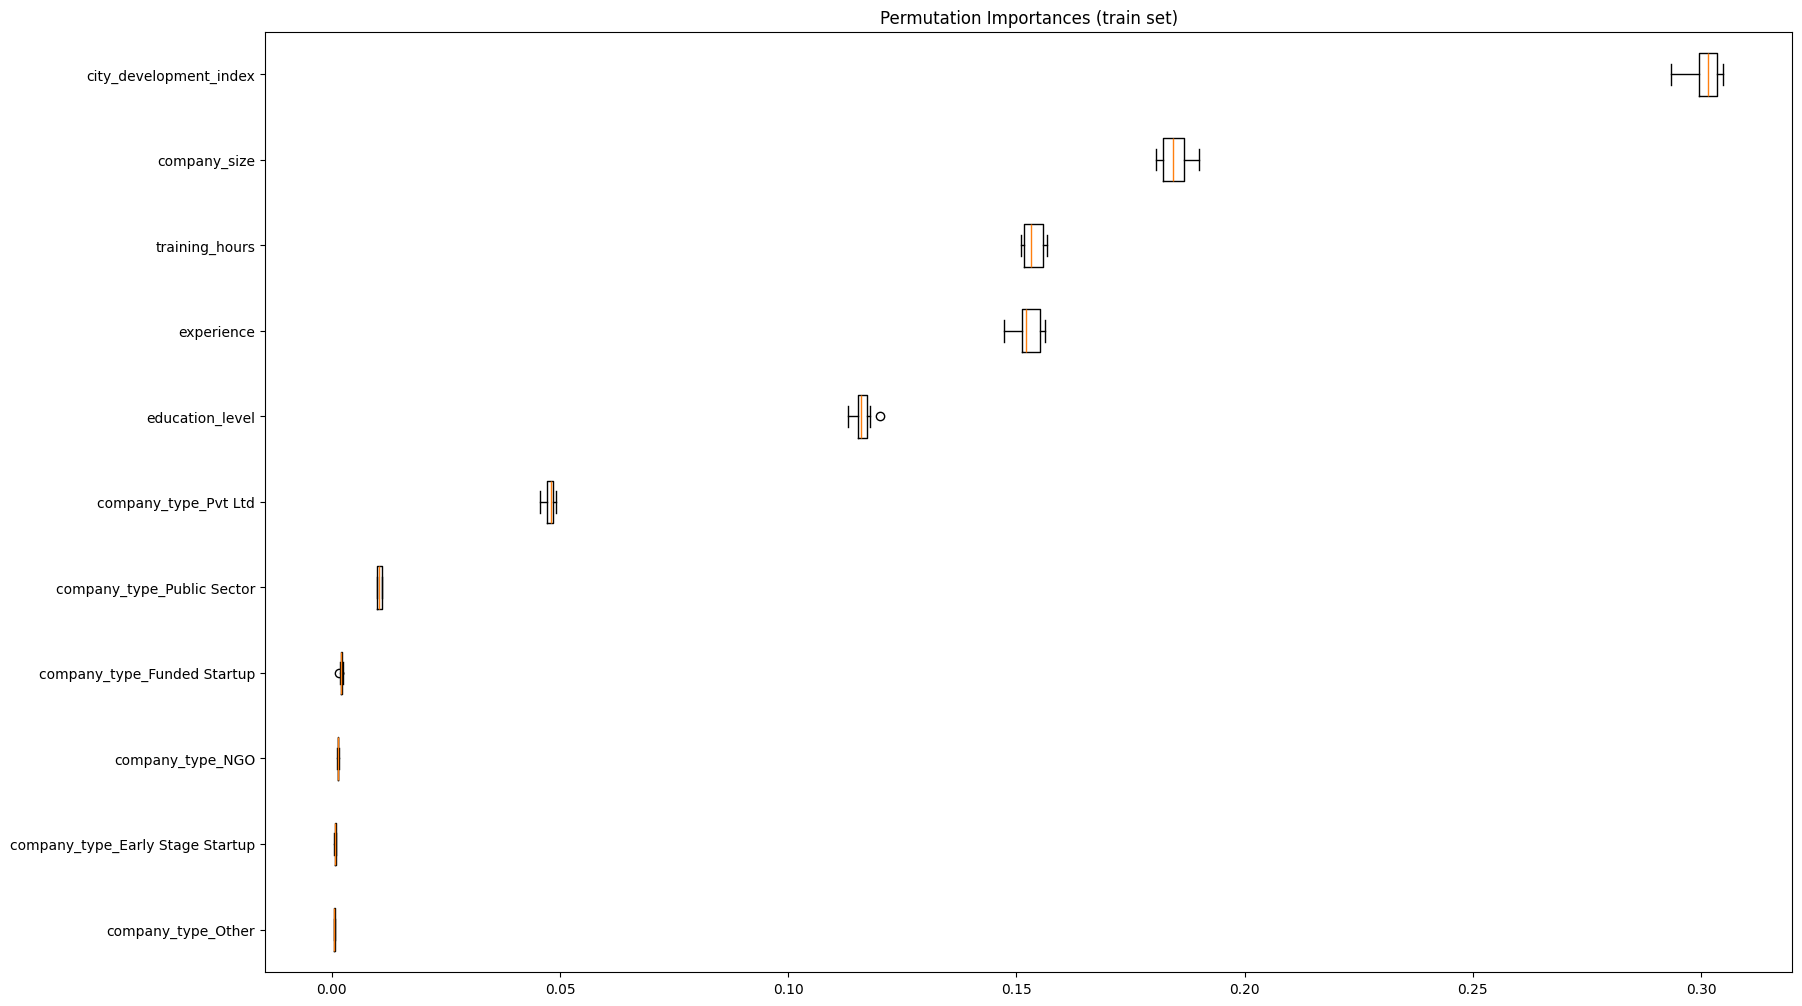

In [ ]:

# Type your answer here
# Update n_repeats=10 and recalculate and visualize feature importance
feature_importances = permutation_importance(estimator=black_box_model, X = X_train, y = y_train, n_repeats=10,
                                random_state=123, n_jobs=2)

visualize_feature_importance(feature_importances)

Partial Dependency Plot (PDP)¶
Partial Dependency Plot (PDP) is an effective way to illustrate the relationship between an interested feature and the model outcome. It essentially visualizes the marginal effects of a feature, that is, shows how the model outcome changes when a specific feature changes in its distribution.

Since a machine learning model may include many features, and it is not feasible to create PDP for every single feature. Thus, we normally first find the most important features via ranking their feature importances. Then, we can only focus PDP on those important features.

From the previous step, we know some important features are city_development_index, company_size, experience, education_level, and we can easily create PDP for those features using plot_partial_dependence in sklearn package.



Let's first try to create PDP for features city_development_index, experience:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance


In [ ]:
feature_importances = permutation_importance(
    estimator=black_box_model,
    X=X_train,
    y=y_train,
    n_repeats=10,
    random_state=123,
    n_jobs=2
)


In [ ]:
def visualize_feature_importance(feature_importances, feature_names):
    sorted_idx = feature_importances.importances_mean.argsort()
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], feature_importances.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title("Feature Importance Based on Permutation")
    plt.show()


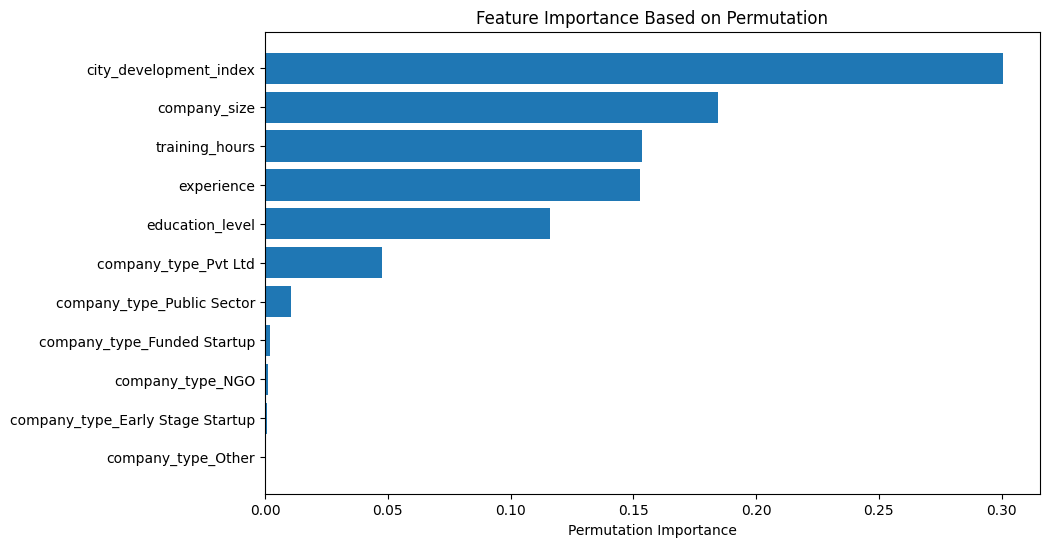

In [ ]:
visualize_feature_importance(feature_importances, feature_names=X_train.columns)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay


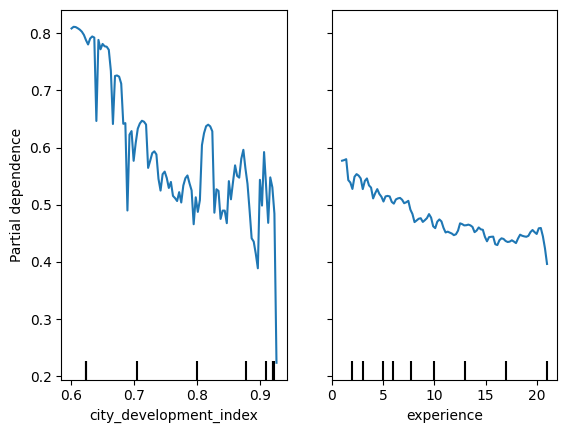

In [ ]:
important_features = ['city_development_index', 'experience']

PartialDependenceDisplay.from_estimator(
    estimator=black_box_model,
    X=X_train,
    features=important_features
)
plt.show()


Then you should see two PDPs are plotted for city_development_index and experience. They all have roughly negative linear relationship betweens the outcome, for example, if an employee is in a well-developed city and has a lot of experiences, then he/she is unlikely to change the current job.


Exercise: Create PDPs for other important features such as company_size, education_level, training_hours, and others

In [ ]:
from sklearn.preprocessing import LabelEncoder

X_train['experience'] = LabelEncoder().fit_transform(X_train['experience'])


In [ ]:
from sklearn.ensemble import RandomForestClassifier

black_box_model = RandomForestClassifier()
black_box_model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [ ]:
!pip install -U scikit-learn


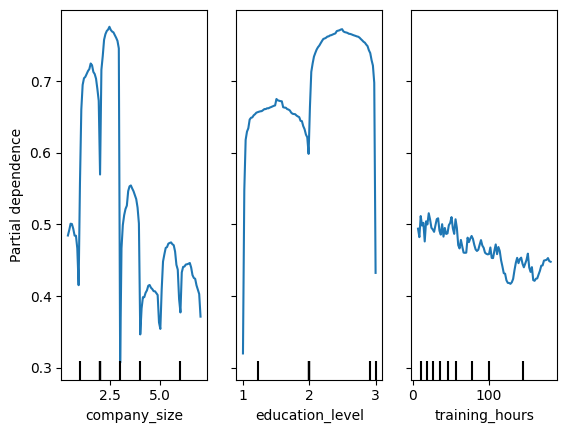

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Define important features
important_features = ['company_size', 'education_level', 'training_hours']

# Generate partial dependence plots
PartialDependenceDisplay.from_estimator(
    estimator=black_box_model,
    X=X_train,
    features=important_features
)

# Show the plot
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

X_train['company_size'] = LabelEncoder().fit_transform(X_train['company_size'])
X_train['education_level'] = LabelEncoder().fit_transform(X_train['education_level'])


In [ ]:
from sklearn.ensemble import RandomForestClassifier

black_box_model = RandomForestClassifier()
black_box_model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [ ]:
!pip install -U scikit-learn


Global Surrogate Model
Now you have explored how to explain the black-box model via analyzing its features. Next, we will learn how to explain it via approximate of their inputs and outputs with a global surrogate model.

We will be training two self-interpretable models: 1) a logistic regression model and 2) a decision tree models using the inputs and outputs from the black-box model

You can follow these general steps to build a global surrogate model:

First, we select a dataset X_test as input

Then, we use the black-box model to make predictions y_blackbox using the X_test

With both training data and labels ready, we can use them to train a simple logistic regression model and a decision tree model

The surrogate model outputs its own predictions y_surrogate

Lastly, we can measure the difference between y_surrogate and y_blackbox using an accuracy score to determine how well the surrogate model approximating the black-box model

Logistic regression surrogate model
In order to compare the coefficients of the logistic regression model directly, we want to normalize the input X first.

In [ ]:
# normalize X_test
min_max_scaler = StandardScaler()
X_test_minmax = min_max_scaler.fit_transform(X_test)

In [ ]:
lm_surrogate = LogisticRegression(max_iter=1000,
                                  random_state=123, penalty='l1', solver='liblinear')
lm_surrogate.fit(X_test_minmax, y_blackbox)

LogisticRegression(max_iter=1000, penalty='l1', random_state=123,
                   solver='liblinear')

Then, we can train a logistic regression model with an L1 regularizer to simplify the model and increase interpretability. Note that y_blackbox is coming from the predictions of black-box model.

In [ ]:
y_surrogate = lm_surrogate.predict(X_test_minmax)

In [ ]:
metrics.accuracy_score(y_blackbox, y_surrogate)

0.7431551499348109

The score is around 0.75 which means the logistic regression surrogate model was able to reproduce about 75% of the original black-box model correctly.

Next, we can start interpreting the much simpler logistic regression model lm_surrogate via analyzing its feature coefficients. We defined a function called get_feature_coeffs to extract and sort feature coefficients from lm_surrogate model:

In [ ]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model):
    coef_dict = {}
    # Filter coefficients less than 0.01
    for coef, feat in zip(regression_model.coef_[0, :], X_test.columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef
    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

In [ ]:
coef_dict = get_feature_coefs(lm_surrogate)
coef_dict

{'city_development_index': -1.1037003758316428,
 'experience': -0.3153460053781262,
 'company_size': -0.31026674911903007,
 'company_type_Funded Startup': -0.2016408367029955,
 'training_hours': -0.15908670450511528,
 'company_type_Early Stage Startup': -0.1313477917545228,
 'company_type_NGO': -0.05280389235903648,
 'company_type_Other': 0.07697385537422016,
 'education_level': 0.15260503732062136,
 'company_type_Pvt Ltd': 0.442463834464927}

coef_dict = get_feature_coefs(lm_surrogate)
coef_dict
We can get a coefficient dict object whose keys are features and values are coefficients, but such dict object is not easy to understand so let's just visualize it using a bar chart:

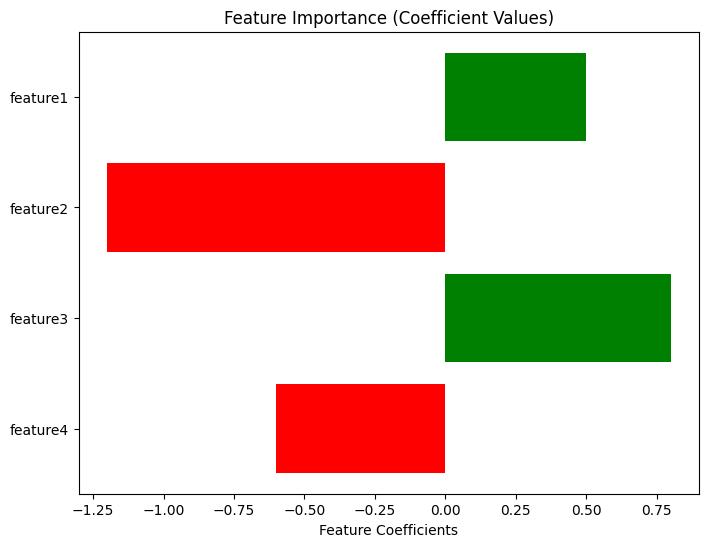

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):
    return ['r' if val <= 0 else 'g' for val in values]

# Visualize coefficients
def visualize_coefs(coef_dict):
    features = list(coef_dict.keys())  # Extract feature names
    values = list(coef_dict.values())  # Extract coefficient values
    y_pos = np.arange(len(features))  # Positions for bars

    color_vals = get_bar_colors(values)  # Assign colors
    plt.rcdefaults()  # Reset plot settings
    fig, ax = plt.subplots(figsize=(8, 6))  # Create figure

    ax.barh(y_pos, values, align='center', color=color_vals)  # Horizontal bar plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)  # Label bars with feature names
    ax.invert_yaxis()  # Labels read from top to bottom
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('Feature Importance (Coefficient Values)')

    plt.show()

# Example dictionary of coefficients
coef_dict = {'feature1': 0.5, 'feature2': -1.2, 'feature3': 0.8, 'feature4': -0.6}

# Call function
visualize_coefs(coef_dict)


From the bar chart above, you can immediately find those important features with negative effects such as city_development_index and experience, and those have positive effects such as education_level or if the company is a Pvt Ltd.








Exercise: Build a global surrogate model using decision tree

In [ ]:
tree_surrogate = DecisionTreeClassifier(random_state=123,
                                         max_depth=5,
                                         max_features=10)

In [ ]:
tree_surrogate.fit(X_test, y_blackbox)
y_surrogate = tree_surrogate.predict(X_test)

In [ ]:
metrics.accuracy_score(y_blackbox, y_surrogate)

0.8213820078226858

In [ ]:
tree_exp = export_text(tree_surrogate, feature_names=list(X_train.columns))

In [ ]:
print(tree_exp)

|--- city_development_index <= 0.70
|   |--- experience <= 20.92
|   |   |--- training_hours <= 304.03
|   |   |   |--- company_type_Funded Startup <= 0.99
|   |   |   |   |--- city_development_index <= 0.69
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- city_development_index >  0.69
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- company_type_Funded Startup >  0.99
|   |   |   |   |--- education_level <= 2.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- education_level >  2.50
|   |   |   |   |   |--- class: 0.0
|   |   |--- training_hours >  304.03
|   |   |   |--- class: 0.0
|   |--- experience >  20.92
|   |   |--- city_development_index <= 0.67
|   |   |   |--- education_level <= 2.07
|   |   |   |   |--- training_hours <= 44.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- training_hours >  44.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- education_level >  2.07
|   |   |   |   |--- company_size <= 6.50
|   |   |   |   |   |--- cla

Local interpretable model-agnostic explanations (LIME)
Global surrogate models may have large prediction inconsistency between the complex black-box model and the simple surrogate models or there are many instance groups or clusters in the dataset which make the surrogate model more generalized to those different patterns and lose the interpretability on a specific data group.

On the other hand, we are also interested in how black-box models make predictions on some representative instances. By understanding these very typical examples, we can sometimes obtain valuable insights without understanding the model’s behaviors on the entire dataset.

Next, you will be building a local surrogate model using LIME method whose general steps are shown in the following flowchart:



We can use a open source lime package to easily build a LIME explainer the our black-box model, let's get started.

First, we need to define a LimeTabularExplainer to explain those predictive models built on structured/tabular datasets, like the job-changing prediction dataset we are using.

Note although LIME algorithm is a local surrogate model, it still also requires a training dataset containing your interested data instances. So that it can perform uniform sampling (feature permutations) around the interested data instances to generate the artificial dataset for the actual surrogate model training process.

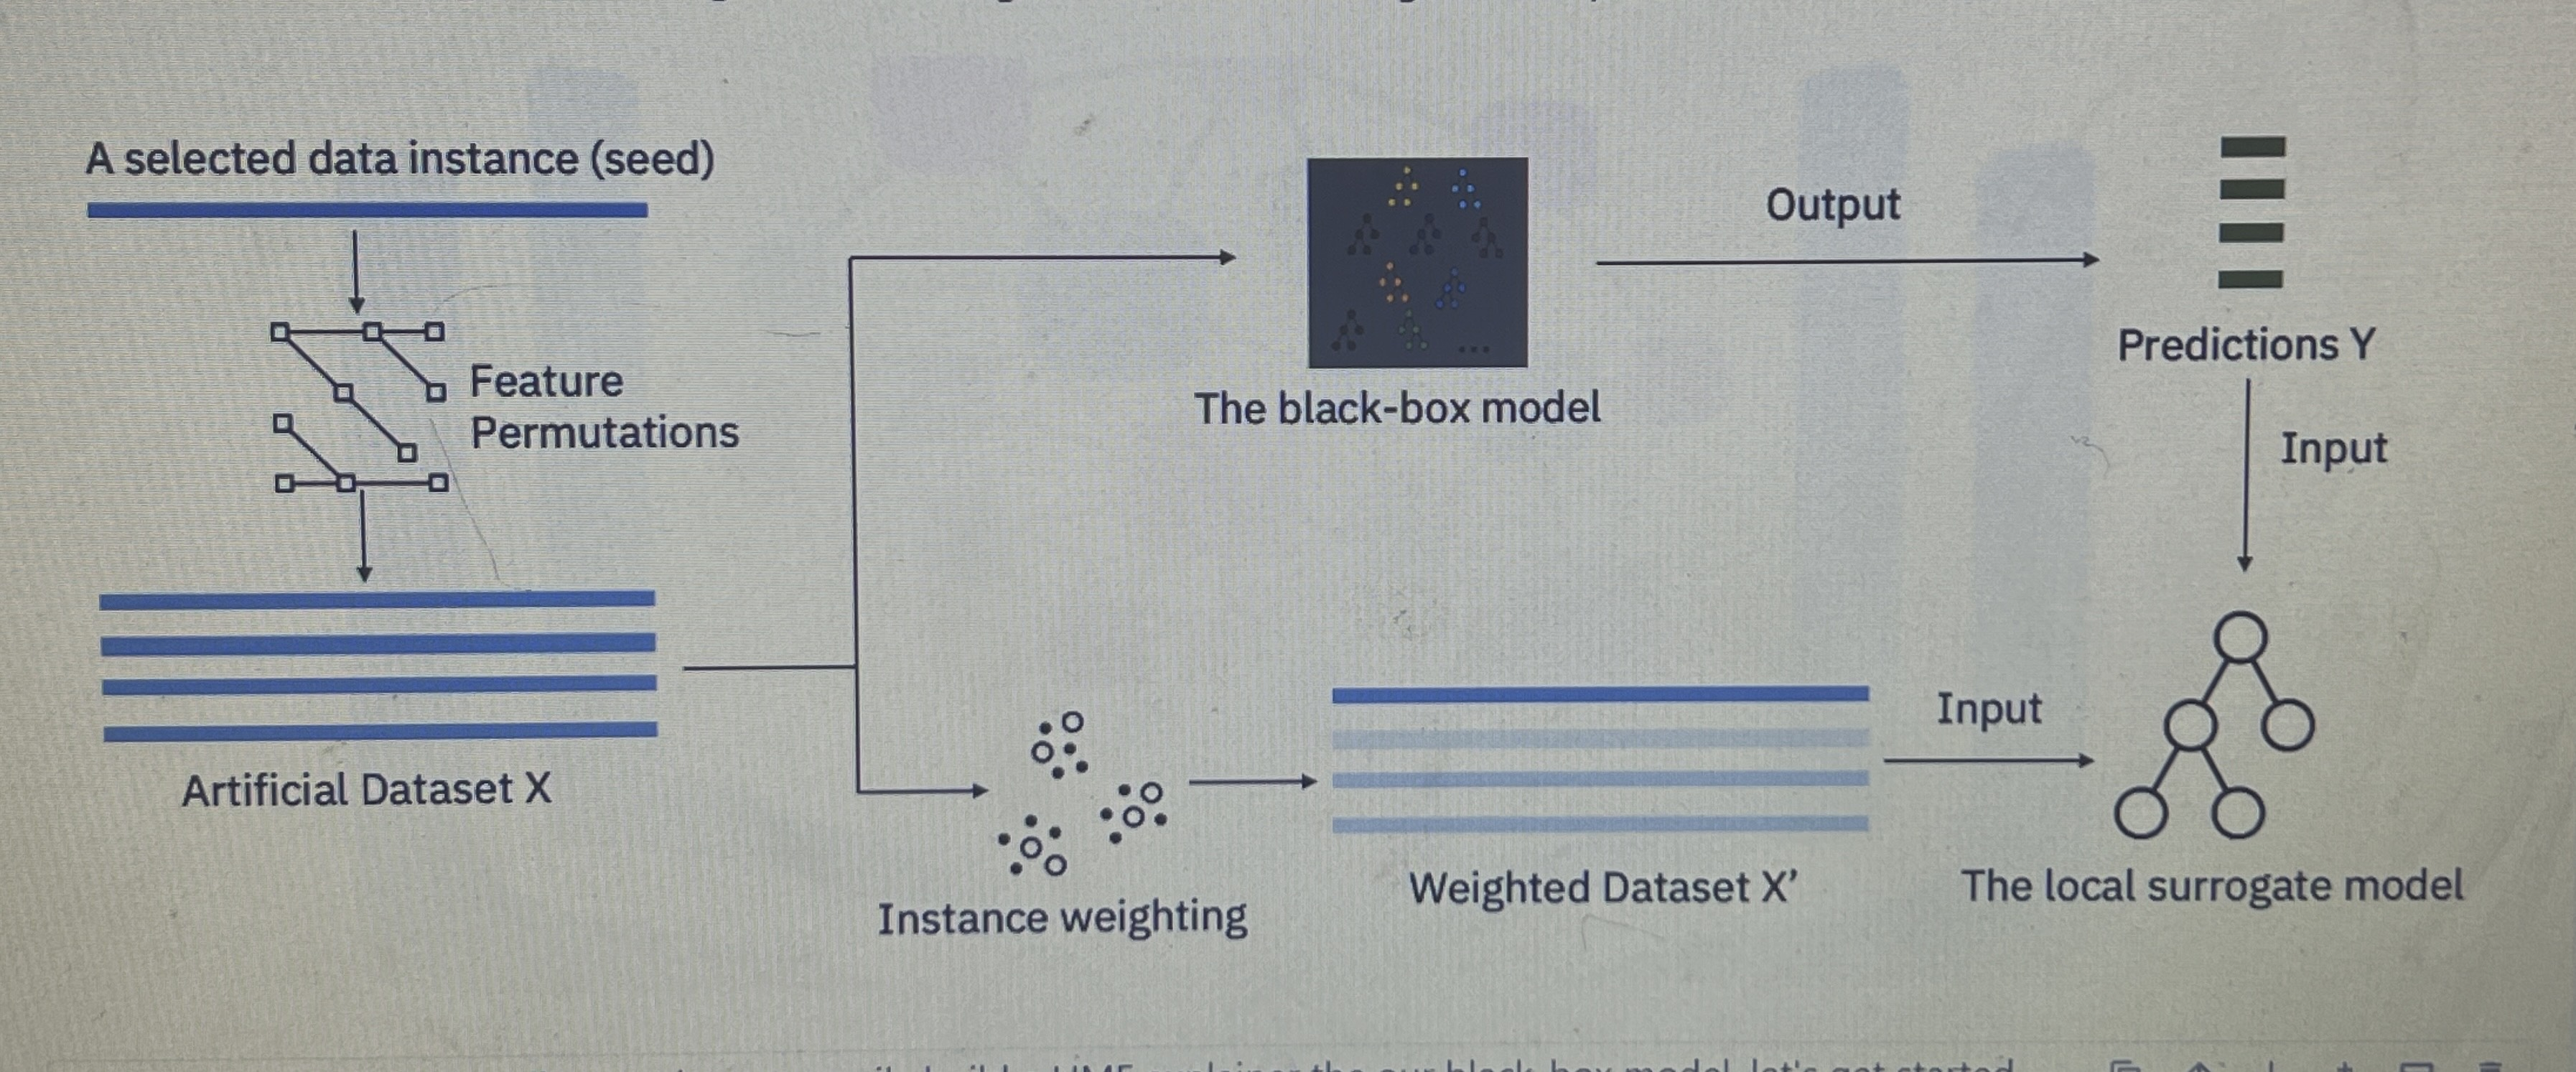

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    # Set the training dataset to be X_test.values (2-D Numpy array)
    training_data=X_test.values,
    # Set the mode to be classification
    mode='classification',
    # Set class names to be `Not Changing` and `Changing`
    class_names = ['Not Changing', 'Changing'],
    # Set feature names
    feature_names=list(X_train.columns),
    random_state=123,
    verbose=True)

Now, let's try to select an interested employee from X_test, and we want to understand its prediction using the LimeTabularExplainer

In [ ]:
instance_index = 19
selected_instance = X_test.iloc[[instance_index]]
lime_test_instance = selected_instance.values.reshape(-1)
selected_instance

,city_development_index,training_hours,company_size,experience,education_level,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
8659,0.924,74.0,7.0,16.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0


Let's make a quick summary about this employee:

His/her city is well-developed with a city development index > 0.9
His/her training hour is 74 hours
His/her company is a very big company, 7 means more than 10,000 employees
His/her experience is more than 16 years
His/her company is a Pvt Ltd (Private) company
His/her has Master's degree(s)
and our black-box model predicts its probability of changing a job is 0.03, that is, very unlikely to leave his or her current job.

Then, let's use LimeTabularExplainer to explain why the black-box model thinks this employee won't leave his/her current job.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Intercept 0.7722094658935206
Prediction_local [0.50760108]
Right: 0.2


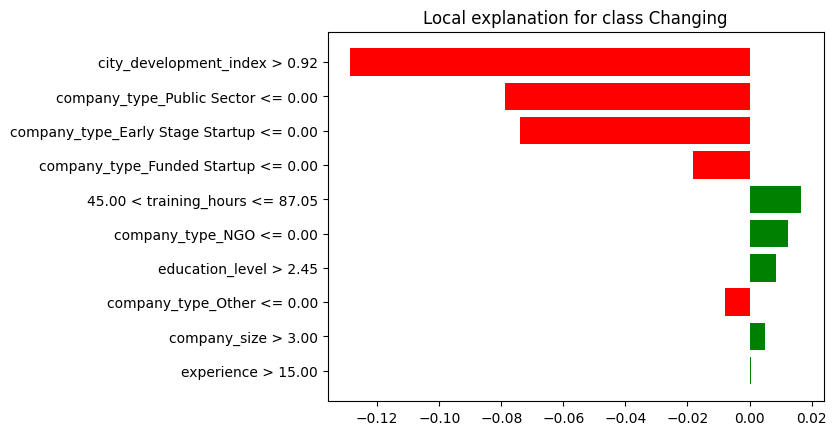

In [ ]:
exp = explainer.explain_instance(
                                 # Instance to explain
                                 lime_test_instance,
                                 # The prediction from black-box model
                                 black_box_model.predict_proba,
                                 # Use max 10 features
                                 num_features=10)
exp.as_pyplot_figure();

LimeTabularExplainer outputs a bar chart similar to the coefficient or feature importance chart we plotted before. From its output, we can easily interpret why the black-box thinks this employe won't change job, based on the following main factors:

His/her company is a very big company
His/her city is well-developed with city development
His/her highest degree is Master or above
His/her experience is more than 15 years
His/her company is not NGO or Startup
This interpretation is also aligned with our common sense, that is, if a well-educated employee has been working in a very big/good private company, located in a big city, for more than 15 years, then he/she is probably very satisfied with current job and does not want to change it.

Exercise: Find other data instances and use LimeTabularExplainer to explain their predictions of black-box mode

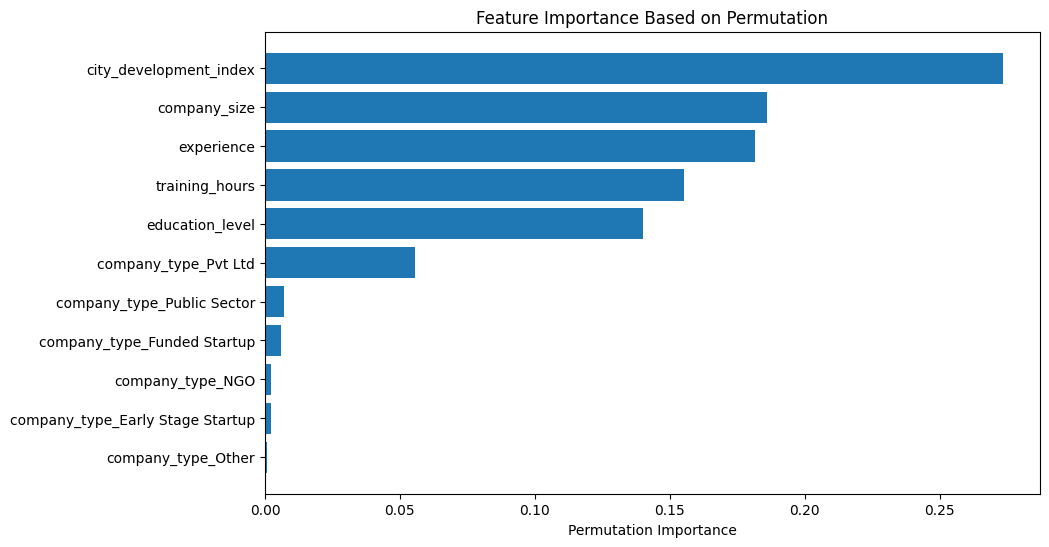

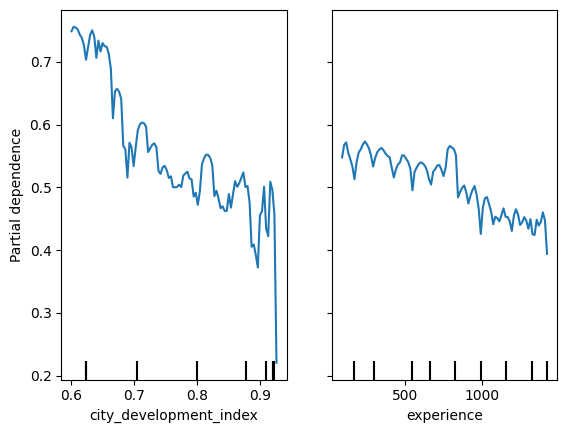

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Ensure X_train is a DataFrame
X_train = pd.DataFrame(X_train, columns=X_train.columns)

# 1️⃣ Compute Feature Importance
feature_importances = permutation_importance(
    estimator=black_box_model,
    X=X_train,
    y=y_train,
    n_repeats=10,
    random_state=123,
    n_jobs=2
)

# 2️⃣ Visualize Feature Importance
def visualize_feature_importance(feature_importances, feature_names):
    sorted_idx = feature_importances.importances_mean.argsort()
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], feature_importances.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title("Feature Importance Based on Permutation")
    plt.show()

visualize_feature_importance(feature_importances, feature_names=X_train.columns)

# 3️⃣ Partial Dependence Plot for Important Features
important_features = ['city_development_index', 'experience']

PartialDependenceDisplay.from_estimator(
    estimator=black_box_model,
    X=X_train,
    features=important_features
)
plt.show()


In [ ]:
!pip install lime==0.2.0.1


In [ ]:
import numpy as np
import lime.lime_tabular


In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Not Looking for Job', 'Looking for Job'],
    mode='classification'
)


In [ ]:
# Update instance_index to another data point (e.g., index 10)
instance_index = 10
instance = X_test.iloc[instance_index]

# Explain the model’s prediction for this specific instance
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=black_box_model.predict_proba
)

# Visualize the Explanation
exp.show_in_notebook()


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.